Задача

🔸Разработать модель, которая будет классифицировать трафик на нормальный и злонамеренный. При этом модель должна работать максимально качественно, так как цена ошибки может быть очень высока.
🔸Оценить качество модели по различным метрикам классификации: precision, recall, f1_score, accuracy.
🔸(*) Деплой: разработать REST API сервис, который будет принимать на вход данные трафика и возвращать класс этого трафика.

## Предварительный анализ данных

### Подготовка данных

#### Загрузка приложений

In [2]:
import os

import pandas as pd
import numpy as np


# Options for pandas
pd.options.display.max_columns = 50
pd.options.display.max_rows = 30

# Display all cell outputs
from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = 'all'
from IPython import get_ipython
ipython = get_ipython()


# autoreload extension
if 'autoreload' not in ipython.extension_manager.loaded:
    %load_ext autoreload
%autoreload 2

#ml
from sklearn.pipeline import Pipeline
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report
from sklearn.model_selection import RandomizedSearchCV
from sklearn.model_selection import GridSearchCV
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import StandardScaler, OrdinalEncoder
from sklearn.impute import SimpleImputer

from sklearn import metrics
from sklearn.metrics import accuracy_score
from sklearn.metrics import f1_score
from sklearn.metrics import roc_auc_score
from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_absolute_error

from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier
from lightgbm import LGBMClassifier
%pip install catboost
from catboost import CatBoostClassifier, Pool

# Visualizations
import matplotlib.pyplot as plt
import seaborn as sns

import plotly
import plotly.express as px
from plotly.subplots import make_subplots
import plotly.graph_objects as go
from plotly.offline import init_notebook_mode, iplot
init_notebook_mode(connected=True)

import warnings
warnings.filterwarnings("ignore")

from google.colab import drive

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 98.7/98.7 MB 10.7 MB/s eta 0:00:00


In [2]:
!pip install imbalanced-learn
#!pip install phik

In [3]:
#немного опций для удобства

pd.options.display.max_rows = 80
pd.set_option('display.max_colwidth', None)
pd.set_option('display.max_columns', None)

large = 16; med = 12; small = 10
params = {'axes.titlesize': large,
          'legend.fontsize': med,
          'figure.figsize': (12, 8),
          'axes.labelsize': med,
          'axes.titlesize': med,
          'xtick.labelsize': med,
          'ytick.labelsize': med,
          'figure.titlesize': large}

plt.rcParams.update(params)
plt.style.use('seaborn-whitegrid')

sns.set_palette('deep')
sns.set_style("whitegrid")


#### Загрузка  файлов

In [4]:
# Для загрузки файлов с Гугл диска

drive.mount('/content/gdrive')

Mounted at /content/gdrive


In [5]:
# загружаем файлы

pth1='https://disk.yandex.ru/d/QYraoEwmfQZ90Q'
pth2='/home/alexandra/data_science/network_traffic_data.csv'
pth3='/content/gdrive/MyDrive/network_traffic_data.csv'

try:
    if os.path.exists(pth1):
        data = pd.read_csv(pth1, delimiter='\,')
    elif os.path.exists(pth2):
        data = pd.read_csv(pth2, delimiter='\,')
    else:
        data = pd.read_csv(pth3, delimiter='\,')

    print('Загрузка файла прошла успешно')

except:
    print('Ошибка загрузки файла. Проверьте путь к файлу.')


Загрузка файла прошла успешно


#### Первичная информация

In [6]:
data

,Destination Port,Flow Duration,Total Fwd Packets,Total Backward Packets,Total Length of Fwd Packets,Total Length of Bwd Packets,Fwd Packet Length Max,Fwd Packet Length Min,Fwd Packet Length Mean,Fwd Packet Length Std,Bwd Packet Length Max,Bwd Packet Length Min,Bwd Packet Length Mean,Bwd Packet Length Std,Flow Bytes/s,Flow Packets/s,Flow IAT Mean,Flow IAT Std,Flow IAT Max,Flow IAT Min,Fwd IAT Total,Fwd IAT Mean,Fwd IAT Std,Fwd IAT Max,Fwd IAT Min,Bwd IAT Total,Bwd IAT Mean,Bwd IAT Std,Bwd IAT Max,Bwd IAT Min,Fwd PSH Flags,Bwd PSH Flags,Fwd URG Flags,Bwd URG Flags,Fwd Header Length,Bwd Header Length,Fwd Packets/s,Bwd Packets/s,Min Packet Length,Max Packet Length,Packet Length Mean,Packet Length Std,Packet Length Variance,FIN Flag Count,SYN Flag Count,RST Flag Count,PSH Flag Count,ACK Flag Count,URG Flag Count,CWE Flag Count,ECE Flag Count,Down/Up Ratio,Average Packet Size,Avg Fwd Segment Size,Avg Bwd Segment Size,Fwd Header Length.1,Fwd Avg Bytes/Bulk,Fwd Avg Packets/Bulk,Fwd Avg Bulk Rate,Bwd Avg Bytes/Bulk,Bwd Avg Packets/Bulk,Bwd Avg Bulk Rate,Subflow Fwd Packets,Subflow Fwd Bytes,Subflow Bwd Packets,Subflow Bwd Bytes,Init_Win_bytes_forward,Init_Win_bytes_backward,act_data_pkt_fwd,min_seg_size_forward,Active Mean,Active Std,Active Max,Active Min,Idle Mean,Idle Std,Idle Max,Idle Min,Label
0,80,5480074,3,1,12,0,6,0,4.000,3.465,0,0,0.0,0.0,2.189751,0.729917,1.826691e+06,3.131700e+06,5442804,101,5480074,2740037.000,3.822290e+06,5442804,37270,0,0.000,0.00,0,0,0,0,0,0,72,32,0.547438,0.182479,0,6,2.4,3.287,1.080000e+01,0,0,0,1,0,0,0,0,0,3.00,4.000,0.0,72,0,0,0,0,0,0,3,12,1,0,8192,42780,2,20,0.0,0.0,0,0,0.0,0.0,0,0,BENIGN
1,443,711977,9,10,703,3950,267,0,78.100,103.300,1448,0,395.0,587.5,6535.323473,26.686255,3.955428e+04,5.015462e+04,120501,1,616301,77037.625,7.299598e+04,215614,230,616874,68541.555,71985.97,199836,1,0,0,0,0,296,328,12.640858,14.045398,0,1448,232.6,442.800,1.960127e+05,0,0,0,1,0,0,0,0,1,244.90,78.100,395.0,296,0,0,0,0,0,0,9,703,10,3950,29200,252,4,32,0.0,0.0,0,0,0.0,0.0,0,0,BENIGN
2,53,153398,2,2,80,224,40,40,40.000,0.000,112,112,112.0,0.0,1981.772904,26.075959,5.113267e+04,8.855831e+04,153391,3,3,3.000,0.000000e+00,3,3,4,4.000,0.00,4,4,0,0,0,0,40,40,13.037980,13.037980,40,112,68.8,39.440,1.555200e+03,0,0,0,0,0,0,0,0,1,86.00,40.000,112.0,40,0,0,0,0,0,0,2,80,2,224,-1,-1,1,20,0.0,0.0,0,0,0.0,0.0,0,0,BENIGN
3,53,57660,1,1,46,128,46,46,46.000,0.000,128,128,128.0,0.0,3017.689906,34.686091,5.766000e+04,0.000000e+00,57660,57660,0,0.000,0.000000e+00,0,0,0,0.000,0.00,0,0,0,0,0,0,20,20,17.343046,17.343046,46,128,73.3,47.340,2.241333e+03,0,0,0,0,0,0,0,0,1,110.00,46.000,128.0,20,0,0,0,0,0,0,1,46,1,128,-1,-1,0,20,0.0,0.0,0,0,0.0,0.0,0,0,BENIGN
4,8446,767,3,1,43,6,31,6,14.336,14.440,6,6,6.0,0.0,63885.267280,5215.123859,2.556667e+02,3.942896e+02,710,3,713,356.500,4.999245e+02,710,3,0,0.000,0.00,0,0,0,0,0,0,60,20,3911.342800,1303.781000,6,31,11.0,11.180,1.250000e+02,0,0,0,0,1,0,0,0,0,13.75,14.336,6.0,60,0,0,0,0,0,0,3,43,1,6,1017,0,2,20,0.0,0.0,0,0,0.0,0.0,0,0,BENIGN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
539611,80,11512204,8,5,326,11632,326,0,40.750,115.250,10184,0,2326.0,4436.0,1038.723775,1.129236,9.593503e+05,2.262616e+06,6507197,1,6510770,930110.000,2.460477e+06,6509948,1,11500000,2878039.500,3378874.20,6507197,196,0,0,0,0,264,168,0.694915,0.434322,0,10184,854.0,2714.000,7.361769e+06,0,0,0,1,0,0,0,0,0,920.00,40.750,2326.0,264,0,0,0,0,0,0,8,326,5,11632,29200,235,1,32,892.0,0.0,892,892,6507197.0,0.0,6507197,6507197,DoS GoldenEye
539612,80,11513325,5,5,471,3525,471,0,94.200,210.600,2077,0,705.0,990.5,347.076105,0.868559,1.279258e+06,2.565153e+06,6508582,53,6512631,1628157.800,3.255639e+06,6511616,176,11500000,2878318.000,3379306.00,6508582,192,0,0,0,0,16

In [7]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 539616 entries, 0 to 539615
Data columns (total 79 columns):
 #   Column                        Non-Null Count   Dtype  
---  ------                        --------------   -----  
 0   Destination Port              539616 non-null  int64  
 1    Flow Duration                539616 non-null  int64  
 2    Total Fwd Packets            539616 non-null  int64  
 3    Total Backward Packets       539616 non-null  int64  
 4   Total Length of Fwd Packets   539616 non-null  int64  
 5    Total Length of Bwd Packets  539616 non-null  int64  
 6    Fwd Packet Length Max        539616 non-null  int64  
 7    Fwd Packet Length Min        539616 non-null  int64  
 8    Fwd Packet Length Mean       539616 non-null  float64
 9    Fwd Packet Length Std        539616 non-null  float64
 10  Bwd Packet Length Max         539616 non-null  int64  
 11   Bwd Packet Length Min        539616 non-null  int64  
 12   Bwd Packet Length Mean       539616 non-nul

Небольшой вывод: данные у нас либо в целочисленном, либо в десятичном формате. Только таргет в формате object. Есть пропуски в столбце 'Flow Bytes/s'. Далее рассмотрим его подробно.

In [8]:
df=data
df['Label'].unique()

array(['BENIGN', 'PortScan', 'DoS Hulk', 'DDoS', 'Bot', 'Infiltration',
       'Web Attack � Brute Force', 'Web Attack � XSS',
       'Web Attack � Sql Injection', 'FTP-Patator', 'SSH-Patator',
       'DoS slowloris', 'DoS Slowhttptest', 'DoS GoldenEye', 'Heartbleed'],
      dtype=object)

<Axes: xlabel='Label'>

Text(0.5, 1.0, 'Распределения по классам')

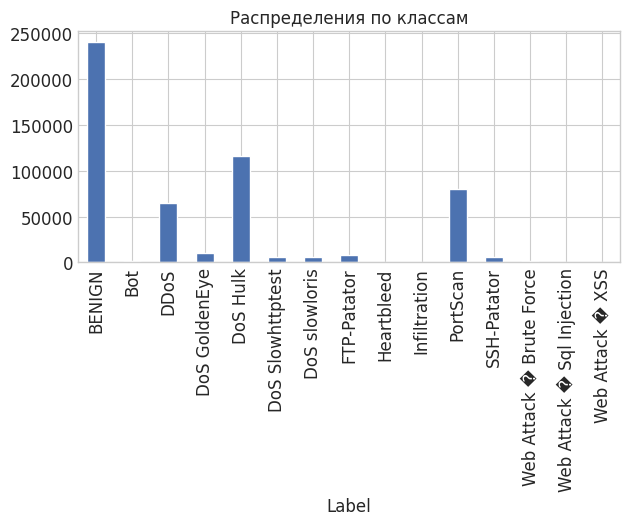

In [9]:
# проверим сбалансированность классов
df.groupby('Label')['Total Length of Fwd Packets'].count().plot.bar(x='Label', figsize=(7,3))

plt.title('Распределения по классам', fontsize=12)
plt.show()

Данные очень разбалансированы, надо будет добавлять баланс классов

### Предобработка данных

#### Заполнение пропусков / удаление дубликатов

In [10]:
df_test=df[df.isnull().any(1)]
df_test['Label'].unique()

array(['BENIGN', 'DoS Hulk'], dtype=object)

В принципе, нулевые строки можно удалить

In [11]:
df=df.dropna ()
df=df.drop_duplicates()

In [12]:
# есть еще строки с бесконечными значениями.

df_test=df[df.isin([np.inf, -np.inf]).any(1)]
df_test['Label'].unique()
df_test=df_test.loc[df_test['Label']=='Bot']

df_test

array(['BENIGN', 'PortScan', 'DDoS', 'Bot', 'FTP-Patator'], dtype=object)

,Destination Port,Flow Duration,Total Fwd Packets,Total Backward Packets,Total Length of Fwd Packets,Total Length of Bwd Packets,Fwd Packet Length Max,Fwd Packet Length Min,Fwd Packet Length Mean,Fwd Packet Length Std,Bwd Packet Length Max,Bwd Packet Length Min,Bwd Packet Length Mean,Bwd Packet Length Std,Flow Bytes/s,Flow Packets/s,Flow IAT Mean,Flow IAT Std,Flow IAT Max,Flow IAT Min,Fwd IAT Total,Fwd IAT Mean,Fwd IAT Std,Fwd IAT Max,Fwd IAT Min,Bwd IAT Total,Bwd IAT Mean,Bwd IAT Std,Bwd IAT Max,Bwd IAT Min,Fwd PSH Flags,Bwd PSH Flags,Fwd URG Flags,Bwd URG Flags,Fwd Header Length,Bwd Header Length,Fwd Packets/s,Bwd Packets/s,Min Packet Length,Max Packet Length,Packet Length Mean,Packet Length Std,Packet Length Variance,FIN Flag Count,SYN Flag Count,RST Flag Count,PSH Flag Count,ACK Flag Count,URG Flag Count,CWE Flag Count,ECE Flag Count,Down/Up Ratio,Average Packet Size,Avg Fwd Segment Size,Avg Bwd Segment Size,Fwd Header Length.1,Fwd Avg Bytes/Bulk,Fwd Avg Packets/Bulk,Fwd Avg Bulk Rate,Bwd Avg Bytes/Bulk,Bwd Avg Packets/Bulk,Bwd Avg Bulk Rate,Subflow Fwd Packets,Subflow Fwd Bytes,Subflow Bwd Packets,Subflow Bwd Bytes,Init_Win_bytes_forward,Init_Win_bytes_backward,act_data_pkt_fwd,min_seg_size_forward,Active Mean,Active Std,Active Max,Active Min,Idle Mean,Idle Std,Idle Max,Idle Min,Label
500037,8080,0,1,1,6,6,6,6,6.0,0.0,6,6,6.0,0.0,inf,inf,0.0,0.0,0,0,0,0.0,0.0,0,0,0,0.0,0.0,0,0,0,0,0,0,20,20,0.0,0.0,6,6,6.0,0.0,0.0,0,0,0,0,1,0,0,0,1,9.0,6.0,6.0,20,0,0,0,0,0,0,1,6,1,6,256,237,0,20,0.0,0.0,0,0,0.0,0.0,0,0,Bot
500129,52235,0,1,1,6,6,6,6,6.0,0.0,6,6,6.0,0.0,inf,inf,0.0,0.0,0,0,0,0.0,0.0,0,0,0,0.0,0.0,0,0,0,0,0,0,20,20,0.0,0.0,6,6,6.0,0.0,0.0,0,0,0,0,1,1,0,0,1,9.0,6.0,6.0,20,0,0,0,0,0,0,1,6,1,6,245,256,0,20,0.0,0.0,0,0,0.0,0.0,0,0,Bot
500585,2846,0,1,1,6,6,6,6,6.0,0.0,6,6,6.0,0.0,inf,inf,0.0,0.0,0,0,0,0.0,0.0,0,0,0,0.0,0.0,0,0,0,0,0,0,20,20,0.0,0.0,6,6,6.0,0.0,0.0,0,0,0,0,1,1,0,0,1,9.0,6.0,6.0,20,0,0,0,0,0,0,1,6,1,6,237,16393,0,20,0.0,0.0,0,0,0.0,0.0,0,0,Bot
500737,2876,0,1,1,6,6,6,6,6.0,0.0,6,6,6.0,0.0,inf,inf,0.0,0.0,0,0,0,0.0,0.0,0,0,0,0.0,0.0,0,0,0,0,0,0,20,20,0.0,0.0,6,6,6.0,0.0,0.0,0,0,0,0,1,1,0,0,1,9.0,6.0,6.0,20,0,0,0,0,0,0,1,6,1,6,237,16393,0,20,0.0,0.0,0,0,0.0,0.0,0,0,Bot
500812,2906,0,1,1,6,6,6,6,6.0,0.0,6,6,6.0,0.0,inf,inf,0.0,0.0,0,0,0,0.0,0.0,0,0,0,0.0,0.0,0,0,0,0,0,0,20,20,0.0,0.0,6,6,6.0,0.0,0.0,0,0,0,0,1,1,0,0,1,9.0,6.0,6.0,20,0,0,0,0,0,0,1,6,1,6,237,16390,0,20,0.0,0.0,0,0,0.0,0.0,0,0,Bot


In [13]:
df=df.replace([np.inf, -np.inf], np.nan)
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 474975 entries, 0 to 539615
Data columns (total 79 columns):
 #   Column                        Non-Null Count   Dtype  
---  ------                        --------------   -----  
 0   Destination Port              474975 non-null  int64  
 1    Flow Duration                474975 non-null  int64  
 2    Total Fwd Packets            474975 non-null  int64  
 3    Total Backward Packets       474975 non-null  int64  
 4   Total Length of Fwd Packets   474975 non-null  int64  
 5    Total Length of Bwd Packets  474975 non-null  int64  
 6    Fwd Packet Length Max        474975 non-null  int64  
 7    Fwd Packet Length Min        474975 non-null  int64  
 8    Fwd Packet Length Mean       474975 non-null  float64
 9    Fwd Packet Length Std        474975 non-null  float64
 10  Bwd Packet Length Max         474975 non-null  int64  
 11   Bwd Packet Length Min        474975 non-null  int64  
 12   Bwd Packet Length Mean       474975 non-nul

In [14]:

#df = df.fillna(0)
#df[df.isin([np.inf, -np.inf]).any(1)]
df = df.fillna(df.max())



Вместо inf были поставлены нули, средние и максимальные значения. Наилучший результат получился при заполнении максимальным значением по столбцу.

In [15]:
cat_columns = [30,31,32,33,43,44,45,46,47,48,49,50]
numeric = df.select_dtypes('float').columns



#### Выделение признаков и таргета

In [16]:
# Делим наши данные
target = df['Label']
features = df.drop('Label', axis=1)


In [17]:
#target=np.reshape(target,-1)

features_test, features_train, target_test, target_train = train_test_split(features, target, test_size=0.80, random_state=12345, stratify=target)

features_val, features_train, target_val, target_train = train_test_split(features_train, target_train, test_size=0.8, random_state=12345, stratify=target_train)


In [18]:
features_train.shape
features_test.shape
features_val.shape

target_train.shape
target_test.shape
target_val.shape

(303984, 78)

(94995, 78)

(75996, 78)

(303984,)

(94995,)

(75996,)

## Построение модели машинного обучения

### Определим функции

In [19]:
def prediction(model):
    preds = model.predict(features_val)
    accuracy=accuracy_score(target_val, preds)
    f1=f1_score(target_val, preds, average='macro')
    target_names = ['BENIGN', 'PortScan', 'DoS Hulk', 'DDoS', 'Bot', 'Infiltration', 'Web Attack � Brute Force', 'Web Attack � XSS',
                    'Web Attack � Sql Injection', 'FTP-Patator', 'SSH-Patator','DoS slowloris', 'DoS Slowhttptest', 'DoS GoldenEye', 'Heartbleed']
    print ("Accuracy:",accuracy)
    print ("F1_macro:", f1)
    print(classification_report(target_val, preds, target_names=target_names))
    return(model)

### Построение бейзлайна

возьмем в качестве байзлайна LogReg

In [20]:
from sklearn.linear_model import LogisticRegression
clf = LogisticRegression(random_state=12345, class_weight='balanced', max_iter=500, ).fit(features_train, target_train)


In [21]:
prediction(clf)

Accuracy: 0.6522974893415443
F1_macro: 0.4745388024806812
                            precision    recall  f1-score   support

                    BENIGN       0.93      0.41      0.57     37244
                  PortScan       0.02      0.27      0.04       312
                  DoS Hulk       0.68      0.97      0.80     10298
                      DDoS       0.74      0.93      0.83      1646
                       Bot       0.95      0.80      0.87     13960
              Infiltration       0.42      0.84      0.56       836
  Web Attack � Brute Force       0.40      0.88      0.55       862
          Web Attack � XSS       0.60      0.66      0.63       949
Web Attack � Sql Injection       0.40      1.00      0.57         2
               FTP-Patator       0.01      1.00      0.02         6
               SSH-Patator       0.47      0.99      0.64      9024
             DoS slowloris       0.77      0.90      0.83       515
          DoS Slowhttptest       0.03      0.05      0.04

LogisticRegression(class_weight='balanced', max_iter=500, random_state=12345)

### Обучение модели

#### CatBoost

In [22]:
# рассмотрим простой CatBoost
model_bas_cb = CatBoostClassifier(cat_features=[30,31,32,33,43,44,45,46,47,48,49,50],
                                  task_type="GPU",
                                  random_state=12345)

model_bas_cb.fit(features_train, target_train)

print(model_bas_cb.get_all_params())

# к сожалению Google Colab не рисует, а очень хотелось посмотреть графики

Learning rate set to 0.208346
0:	learn: 0.7103990	total: 49.4ms	remaining: 49.3s
1:	learn: 0.5330124	total: 105ms	remaining: 52.6s
2:	learn: 0.4251299	total: 160ms	remaining: 53.1s
3:	learn: 0.3508356	total: 215ms	remaining: 53.7s
4:	learn: 0.2924896	total: 266ms	remaining: 53s
5:	learn: 0.2478457	total: 306ms	remaining: 50.6s
6:	learn: 0.2095375	total: 331ms	remaining: 47s
7:	learn: 0.1809451	total: 358ms	remaining: 44.4s
8:	learn: 0.1571204	total: 385ms	remaining: 42.4s
9:	learn: 0.1388515	total: 411ms	remaining: 40.6s
10:	learn: 0.1221289	total: 439ms	remaining: 39.5s
11:	learn: 0.1093289	total: 474ms	remaining: 39s
12:	learn: 0.0976664	total: 499ms	remaining: 37.9s
13:	learn: 0.0869762	total: 524ms	remaining: 36.9s
14:	learn: 0.0789329	total: 547ms	remaining: 36s
15:	learn: 0.0718294	total: 579ms	remaining: 35.6s
16:	learn: 0.0662951	total: 602ms	remaining: 34.8s
17:	learn: 0.0616462	total: 626ms	remaining: 34.2s
18:	learn: 0.0551420	total: 649ms	remaining: 33.5s
19:	learn: 0.05205

{'nan_mode': 'Min', 'gpu_ram_part': 0.95, 'eval_metric': 'MultiClass', 'combinations_ctr': ['Borders:CtrBorderCount=15:CtrBorderType=Uniform:TargetBorderCount=1:TargetBorderType=MinEntropy:Prior=0/1:Prior=0.5/1:Prior=1/1', 'FeatureFreq:CtrBorderCount=15:CtrBorderType=Median:Prior=0/1'], 'iterations': 1000, 'fold_permutation_block': 64, 'leaf_estimation_method': 'Newton', 'observations_to_bootstrap': 'TestOnly', 'random_score_type': 'NormalWithModelSizeDecrease', 'counter_calc_method': 'SkipTest', 'grow_policy': 'SymmetricTree', 'penalties_coefficient': 1, 'boosting_type': 'Plain', 'ctr_history_unit': 'Sample', 'feature_border_type': 'GreedyLogSum', 'bayesian_matrix_reg': 0.10000000149011612, 'one_hot_max_size': 2, 'devices': '-1', 'eval_fraction': 0, 'pinned_memory_bytes': '104857600', 'force_unit_auto_pair_weights': False, 'l2_leaf_reg': 3, 'random_strength': 1, 'rsm': 1, 'boost_from_average': False, 'gpu_cat_features_storage': 'GpuRam', 'fold_size_loss_normalization': False, 'max_ctr

In [23]:
prediction(model_bas_cb)

Accuracy: 0.9973682825411864
F1_macro: 0.9175435844452597
                            precision    recall  f1-score   support

                    BENIGN       1.00      1.00      1.00     37244
                  PortScan       0.94      0.97      0.96       312
                  DoS Hulk       1.00      1.00      1.00     10298
                      DDoS       1.00      1.00      1.00      1646
                       Bot       1.00      1.00      1.00     13960
              Infiltration       1.00      0.99      0.99       836
  Web Attack � Brute Force       1.00      0.99      0.99       862
          Web Attack � XSS       1.00      1.00      1.00       949
Web Attack � Sql Injection       1.00      1.00      1.00         2
               FTP-Patator       1.00      1.00      1.00         6
               SSH-Patator       1.00      1.00      1.00      9024
             DoS slowloris       1.00      1.00      1.00       515
          DoS Slowhttptest       0.72      0.80      0.76

Небольшой вывод: В целом, даже простой CatBoost существенно лучше Baseline.

Надо научить модель распознавать классы: DoS Slowhttptest, DoS GoldenEye и Heartbleed. Именно их модель сильно путает.

In [24]:
importances = model_bas_cb.feature_importances_  # train_features is the dataframe of training features
feature_list = list(features_val.columns)  # Extract the feature importances into a dataframe
feature_results = pd.DataFrame({'feature': feature_list,'importance': importances})  # Show the top 10 most important
feature_results = feature_results.sort_values('importance',ascending = False).reset_index(drop=True)
feature_results.tail(50)

,feature,importance
28,Bwd Packet Length Mean,1.030737e+00
29,Bwd IAT Min,1.024658e+00
30,Subflow Bwd Bytes,8.341108e-01
31,URG Flag Count,7.683885e-01
32,ACK Flag Count,7.245434e-01
33,Bwd Packet Length Max,6.657735e-01
34,Fwd IAT Max,6.619831e-01
35,Fwd IAT Mean,6.048312e-01
36,Bwd IAT Mean,5.883093e-01
37,Bwd IAT Std,5.444477e-01


Попробуем удалить столбец, который в конце списка

In [25]:
features_train_1 = features_train.drop(' RST Flag Count', axis=1)
features_val_1 = features_val.drop(' RST Flag Count', axis=1)

model_bas_cb = CatBoostClassifier(cat_features=[30,31,32,33,43,44,45,46,47,48,49],
                                  task_type="GPU",
                                  random_state=12345)

model_bas_cb.fit(features_train_1, target_train)

preds = model_bas_cb.predict(features_val_1)
print ("Accuracy:",accuracy_score(target_val, preds))
print ("F1_macro:", f1_score(target_val, preds, average='macro'))
target_names = ['BENIGN', 'PortScan', 'DoS Hulk', 'DDoS', 'Bot', 'Infiltration', 'Web Attack � Brute Force', 'Web Attack � XSS',
                'Web Attack � Sql Injection', 'FTP-Patator', 'SSH-Patator','DoS slowloris', 'DoS Slowhttptest', 'DoS GoldenEye', 'Heartbleed']

print(classification_report(target_val, preds, target_names=target_names))

Learning rate set to 0.208346
0:	learn: 0.7103990	total: 51.4ms	remaining: 51.3s
1:	learn: 0.5330124	total: 107ms	remaining: 53.4s
2:	learn: 0.4251299	total: 152ms	remaining: 50.6s
3:	learn: 0.3508356	total: 198ms	remaining: 49.2s
4:	learn: 0.2924897	total: 238ms	remaining: 47.3s
5:	learn: 0.2478458	total: 277ms	remaining: 45.9s
6:	learn: 0.2095375	total: 312ms	remaining: 44.2s
7:	learn: 0.1809451	total: 342ms	remaining: 42.4s
8:	learn: 0.1571204	total: 366ms	remaining: 40.3s
9:	learn: 0.1388515	total: 390ms	remaining: 38.6s
10:	learn: 0.1221289	total: 427ms	remaining: 38.4s
11:	learn: 0.1093289	total: 466ms	remaining: 38.4s
12:	learn: 0.0976665	total: 490ms	remaining: 37.2s
13:	learn: 0.0869762	total: 515ms	remaining: 36.3s
14:	learn: 0.0789329	total: 543ms	remaining: 35.6s
15:	learn: 0.0718294	total: 566ms	remaining: 34.8s
16:	learn: 0.0662951	total: 589ms	remaining: 34.1s
17:	learn: 0.0616462	total: 623ms	remaining: 34s
18:	learn: 0.0551420	total: 645ms	remaining: 33.3s
19:	learn: 0

Accuracy: 0.9973682825411864
F1_macro: 0.9175435844452597
                            precision    recall  f1-score   support

                    BENIGN       1.00      1.00      1.00     37244
                  PortScan       0.94      0.97      0.96       312
                  DoS Hulk       1.00      1.00      1.00     10298
                      DDoS       1.00      1.00      1.00      1646
                       Bot       1.00      1.00      1.00     13960
              Infiltration       1.00      0.99      0.99       836
  Web Attack � Brute Force       1.00      0.99      0.99       862
          Web Attack � XSS       1.00      1.00      1.00       949
Web Attack � Sql Injection       1.00      1.00      1.00         2
               FTP-Patator       1.00      1.00      1.00         6
               SSH-Patator       1.00      1.00      1.00      9024
             DoS slowloris       1.00      1.00      1.00       515
          DoS Slowhttptest       0.72      0.80      0.76

Удалим еще один столбец из конца списка

In [26]:
features_train_2 = features_train_1.drop(' SYN Flag Count', axis=1)
features_val_2 = features_val_1.drop(' SYN Flag Count', axis=1)

model_bas_cb = CatBoostClassifier(cat_features=[30,31,32,33,43,44,45,46,47,48],
                                  task_type="GPU",
                                  random_state=12345)

model_bas_cb.fit(features_train_2, target_train)

preds = model_bas_cb.predict(features_val_2)
print ("Accuracy:",accuracy_score(target_val, preds))
print ("F1_macro:", f1_score(target_val, preds, average='macro'))
target_names = ['BENIGN', 'PortScan', 'DoS Hulk', 'DDoS', 'Bot', 'Infiltration', 'Web Attack � Brute Force', 'Web Attack � XSS',
                'Web Attack � Sql Injection', 'FTP-Patator', 'SSH-Patator','DoS slowloris', 'DoS Slowhttptest', 'DoS GoldenEye', 'Heartbleed']

print(classification_report(target_val, preds, target_names=target_names))

Learning rate set to 0.208346
0:	learn: 0.7103989	total: 99.1ms	remaining: 1m 38s
1:	learn: 0.5330125	total: 207ms	remaining: 1m 43s
2:	learn: 0.4251299	total: 317ms	remaining: 1m 45s
3:	learn: 0.3508356	total: 442ms	remaining: 1m 49s
4:	learn: 0.2924896	total: 550ms	remaining: 1m 49s
5:	learn: 0.2478457	total: 659ms	remaining: 1m 49s
6:	learn: 0.2095375	total: 752ms	remaining: 1m 46s
7:	learn: 0.1809451	total: 844ms	remaining: 1m 44s
8:	learn: 0.1571204	total: 944ms	remaining: 1m 43s
9:	learn: 0.1388515	total: 1.03s	remaining: 1m 42s
10:	learn: 0.1221289	total: 1.14s	remaining: 1m 42s
11:	learn: 0.1093289	total: 1.24s	remaining: 1m 41s
12:	learn: 0.0976665	total: 1.33s	remaining: 1m 41s
13:	learn: 0.0869762	total: 1.43s	remaining: 1m 40s
14:	learn: 0.0789329	total: 1.53s	remaining: 1m 40s
15:	learn: 0.0718294	total: 1.62s	remaining: 1m 39s
16:	learn: 0.0662951	total: 1.71s	remaining: 1m 38s
17:	learn: 0.0616462	total: 1.8s	remaining: 1m 38s
18:	learn: 0.0551420	total: 1.89s	remaining:

Accuracy: 0.9973682825411864
F1_macro: 0.9175435844452597
                            precision    recall  f1-score   support

                    BENIGN       1.00      1.00      1.00     37244
                  PortScan       0.94      0.97      0.96       312
                  DoS Hulk       1.00      1.00      1.00     10298
                      DDoS       1.00      1.00      1.00      1646
                       Bot       1.00      1.00      1.00     13960
              Infiltration       1.00      0.99      0.99       836
  Web Attack � Brute Force       1.00      0.99      0.99       862
          Web Attack � XSS       1.00      1.00      1.00       949
Web Attack � Sql Injection       1.00      1.00      1.00         2
               FTP-Patator       1.00      1.00      1.00         6
               SSH-Patator       1.00      1.00      1.00      9024
             DoS slowloris       1.00      1.00      1.00       515
          DoS Slowhttptest       0.72      0.80      0.76

Вывод: если убирать столбцы, то вроде бы результат не меняется... Однако, это такой опасный путь, непонятно сколько столбцов убрать и имеет ли это смысл...

#### Масштабирование данных

In [27]:
# кодируем признаки
#!pip install -U scikit-learn

col_transformer = ColumnTransformer(transformers=[('ss', StandardScaler(), numeric),('oe', OrdinalEncoder(), cat_columns)], remainder='drop')


features_train_oe = col_transformer.fit_transform(features_train)



In [28]:
#убираем выбросы
features_train.shape

for name, values in features_train[numeric].iteritems():
    upper_lim = features_train[name].quantile(.95)
    lower_lim = features_train[name].quantile(.05)
    features_train.loc[(features_train[name] > upper_lim),name] = upper_lim
    features_train.loc[(features_train[name] < lower_lim),name] = lower_lim

features_train.shape

(303984, 78)

(303984, 78)

#### Построение пайплайна

In [29]:
pipe_kNN = Pipeline([('clf', KNeighborsClassifier())])

pipe_rfr = Pipeline([('clf', RandomForestClassifier(random_state=12345, class_weight='balanced'))])

pipe_lgbm = Pipeline([('clf', LGBMClassifier(boosting_type='gbdt', force_row_wise=True, error_score='raise'))])





In [30]:
grid_params_cbc = [{'clf__n_neighbors': range(2,5,1)}]

grid_params_rfr = [{'clf__max_depth': range(7,20,3), 'clf__n_estimators': range(200, 500, 100)}]

grid_params_lgbm = [{'clf__max_depth': range(1,8,3),
                     'clf__n_estimators': range(1, 50, 10),
                     'clf__num_leaves': range(1,7,2)}]

kNN = GridSearchCV(estimator=pipe_kNN,
                   param_grid=grid_params_cbc,
                   scoring='f1_macro',
                   cv=5)

RFR = GridSearchCV(estimator=pipe_rfr,
                   param_grid=grid_params_rfr,
                   scoring='f1_macro',
                   cv=5)

LGBM = GridSearchCV(estimator=pipe_lgbm,
                    param_grid=grid_params_lgbm,
                    scoring='f1_macro',
                    cv=5)

grids = [kNN, LGBM, RFR]

grid_dict = {0: 'kNN',
             1: 'LGBMClassifier',
             2: 'RandomForestC'}

In [31]:
print('Performing model optimizations...')
best_acc = -100.0
best_clf = 0
best_gs = ''
for idx, gs in enumerate(grids):
    print('\nEstimator: %s' % grid_dict[idx])
    gs.fit(features_train, target_train)
    print('Best params are : %s' % gs.best_params_)
    print('Best training accuracy: %.3f' % gs.best_score_)
    if  gs.best_score_ > best_acc:
        best_acc = gs.best_score_
        best_gs = gs
        best_clf = idx
        best_param = gs.best_params_

print('\nClassifier with best test set accuracy: %s' % grid_dict[best_clf])

Performing model optimizations...

Estimator: kNN


GridSearchCV(cv=5, estimator=Pipeline(steps=[('clf', KNeighborsClassifier())]),
             param_grid=[{'clf__n_neighbors': range(2, 5)}],
             scoring='f1_macro')

Best params are : {'clf__n_neighbors': 2}
Best training accuracy: 0.781

Estimator: LGBMClassifier
[LightGBM] [Warning] Unknown parameter: error_score
[LightGBM] [Warning] Unknown parameter: error_score
[LightGBM] [Warning] Unknown parameter: error_score
[LightGBM] [Warning] Unknown parameter: error_score
[LightGBM] [Warning] Unknown parameter: error_score
[LightGBM] [Warning] Unknown parameter: error_score
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Warning] Unknown parameter: error_score
[LightGBM] [Info] Total Bins 14256
[LightGBM] [Info] Number of data points in the train set: 243187, number of used features: 67
[LightGBM] [Info] Start training from score -0.713204
[LightGBM] [Info] Start training from score -5.493831
[LightGBM] [Info] Start training from score -1.998688
[LightGBM] [Info] Start training from score -3.832560
[LightGBM] [Info] Start training from score -1.694529
[LightGBM] [Info] Start training from score -4.509134
[Lig

GridSearchCV(cv=5,
             estimator=Pipeline(steps=[('clf',
                                        LGBMClassifier(error_score='raise',
                                                       force_row_wise=True))]),
             param_grid=[{'clf__max_depth': range(1, 8, 3),
                          'clf__n_estimators': range(1, 50, 10),
                          'clf__num_leaves': range(1, 7, 2)}],
             scoring='f1_macro')

Best params are : {'clf__max_depth': 4, 'clf__n_estimators': 11, 'clf__num_leaves': 5}
Best training accuracy: 0.681

Estimator: RandomForestC


GridSearchCV(cv=5,
             estimator=Pipeline(steps=[('clf',
                                        RandomForestClassifier(class_weight='balanced',
                                                               random_state=12345))]),
             param_grid=[{'clf__max_depth': range(7, 20, 3),
                          'clf__n_estimators': range(200, 500, 100)}],
             scoring='f1_macro')

Best params are : {'clf__max_depth': 19, 'clf__n_estimators': 300}
Best training accuracy: 0.869

Classifier with best test set accuracy: RandomForestC


In [42]:
data_pip = pd.DataFrame({'Мethod': ['LogisticRegression', 'KNeighborsClassifier', 'RandomForestClassifier', 'LGBMClassifier'],
                         'F1_macro': [0.468, 0.781, 0.869, 0.681]})

data_pip

,Мethod,F1_macro
0,LogisticRegression,0.468
1,KNeighborsClassifier,0.781
2,RandomForestClassifier,0.869
3,LGBMClassifier,0.681


По итогам прогона pipeline, лучшие результаты из этих моделей показала модель случайного леса.


#### Улучшаем модель

In [37]:
model_rfc=RandomForestClassifier(max_depth=20,
                                 n_estimators=400,
                                 random_state=12345,
                                 class_weight='balanced')

model_rfc.fit(features_train, target_train)



RandomForestClassifier(class_weight='balanced', max_depth=20, n_estimators=400,
                       random_state=12345)

In [38]:
prediction(model_rfc)

Accuracy: 0.9956839833675457
F1_macro: 0.8939749904569199
                            precision    recall  f1-score   support

                    BENIGN       1.00      1.00      1.00     37244
                  PortScan       0.71      0.99      0.83       312
                  DoS Hulk       1.00      1.00      1.00     10298
                      DDoS       1.00      1.00      1.00      1646
                       Bot       1.00      1.00      1.00     13960
              Infiltration       1.00      0.99      1.00       836
  Web Attack � Brute Force       1.00      0.99      0.99       862
          Web Attack � XSS       1.00      1.00      1.00       949
Web Attack � Sql Injection       1.00      1.00      1.00         2
               FTP-Patator       1.00      1.00      1.00         6
               SSH-Patator       1.00      1.00      1.00      9024
             DoS slowloris       1.00      1.00      1.00       515
          DoS Slowhttptest       0.76      0.74      0.75

RandomForestClassifier(class_weight='balanced', max_depth=20, n_estimators=400,
                       random_state=12345)

In [39]:
# улучшаем CatBOOst

model_bas_cb = CatBoostClassifier(task_type="GPU",
                                  random_state=12345,
                                  learning_rate=0.15,
                                  custom_loss=['AUC'],
                                  )

model_bas_cb.fit(features_train, target_train,
                 eval_set=(features_train, target_train))

print(model_bas_cb.get_all_params())

Default metric period is 5 because AUC is/are not implemented for GPU
AUC is not implemented on GPU. Will use CPU for metric computation, this could significantly affect learning time


0:	learn: 1.0999364	test: 1.0999366	best: 1.0999366 (0)	total: 327ms	remaining: 5m 26s
1:	total: 376ms	remaining: 3m 7s
2:	total: 424ms	remaining: 2m 20s
3:	total: 477ms	remaining: 1m 58s
4:	total: 523ms	remaining: 1m 44s
5:	learn: 0.4333591	test: 0.4333590	best: 0.4333590 (5)	total: 747ms	remaining: 2m 3s
6:	total: 775ms	remaining: 1m 49s
7:	total: 802ms	remaining: 1m 39s
8:	total: 829ms	remaining: 1m 31s
9:	total: 855ms	remaining: 1m 24s
10:	learn: 0.2302713	test: 0.2302713	best: 0.2302713 (10)	total: 1.07s	remaining: 1m 36s
11:	total: 1.09s	remaining: 1m 29s
12:	total: 1.11s	remaining: 1m 24s
13:	total: 1.14s	remaining: 1m 20s
14:	total: 1.17s	remaining: 1m 17s
15:	learn: 0.1386107	test: 0.1386106	best: 0.1386106 (15)	total: 1.4s	remaining: 1m 25s
16:	total: 1.42s	remaining: 1m 22s
17:	total: 1.45s	remaining: 1m 18s
18:	total: 1.47s	remaining: 1m 15s
19:	total: 1.5s	remaining: 1m 13s
20:	learn: 0.0901550	test: 0.0901550	best: 0.0901550 (20)	total: 1.73s	remaining: 1m 20s
21:	total: 

{'nan_mode': 'Min', 'gpu_ram_part': 0.95, 'eval_metric': 'MultiClass', 'iterations': 1000, 'leaf_estimation_method': 'Newton', 'observations_to_bootstrap': 'TestOnly', 'random_score_type': 'NormalWithModelSizeDecrease', 'grow_policy': 'SymmetricTree', 'penalties_coefficient': 1, 'boosting_type': 'Plain', 'feature_border_type': 'GreedyLogSum', 'bayesian_matrix_reg': 0.10000000149011612, 'devices': '-1', 'eval_fraction': 0, 'pinned_memory_bytes': '104857600', 'force_unit_auto_pair_weights': False, 'l2_leaf_reg': 3, 'random_strength': 1, 'rsm': 1, 'boost_from_average': False, 'gpu_cat_features_storage': 'GpuRam', 'fold_size_loss_normalization': False, 'model_size_reg': 0.5, 'pool_metainfo_options': {'tags': {}}, 'use_best_model': True, 'meta_l2_frequency': 0, 'class_names': ['BENIGN', 'Bot', 'DDoS', 'DoS GoldenEye', 'DoS Hulk', 'DoS Slowhttptest', 'DoS slowloris', 'FTP-Patator', 'Heartbleed', 'Infiltration', 'PortScan', 'SSH-Patator', 'Web Attack � Brute Force', 'Web Attack � Sql Injectio

In [40]:
prediction(model_bas_cb)

Accuracy: 0.997486709826833
F1_macro: 0.9299855030838736
                            precision    recall  f1-score   support

                    BENIGN       1.00      1.00      1.00     37244
                  PortScan       0.94      0.98      0.96       312
                  DoS Hulk       1.00      1.00      1.00     10298
                      DDoS       1.00      1.00      1.00      1646
                       Bot       1.00      1.00      1.00     13960
              Infiltration       0.99      0.99      0.99       836
  Web Attack � Brute Force       1.00      0.99      0.99       862
          Web Attack � XSS       1.00      1.00      1.00       949
Web Attack � Sql Injection       1.00      1.00      1.00         2
               FTP-Patator       1.00      1.00      1.00         6
               SSH-Patator       1.00      1.00      1.00      9024
             DoS slowloris       1.00      1.00      1.00       515
          DoS Slowhttptest       0.73      0.85      0.78 

Посмотрим, что там в классе Heartbleed. Непонятно почему он хуже всего воспроизводится.

In [41]:
df.loc[df['Label']=='Heartbleed'].head(30)


,Destination Port,Flow Duration,Total Fwd Packets,Total Backward Packets,Total Length of Fwd Packets,Total Length of Bwd Packets,Fwd Packet Length Max,Fwd Packet Length Min,Fwd Packet Length Mean,Fwd Packet Length Std,Bwd Packet Length Max,Bwd Packet Length Min,Bwd Packet Length Mean,Bwd Packet Length Std,Flow Bytes/s,Flow Packets/s,Flow IAT Mean,Flow IAT Std,Flow IAT Max,Flow IAT Min,Fwd IAT Total,Fwd IAT Mean,Fwd IAT Std,Fwd IAT Max,Fwd IAT Min,Bwd IAT Total,Bwd IAT Mean,Bwd IAT Std,Bwd IAT Max,Bwd IAT Min,Fwd PSH Flags,Bwd PSH Flags,Fwd URG Flags,Bwd URG Flags,Fwd Header Length,Bwd Header Length,Fwd Packets/s,Bwd Packets/s,Min Packet Length,Max Packet Length,Packet Length Mean,Packet Length Std,Packet Length Variance,FIN Flag Count,SYN Flag Count,RST Flag Count,PSH Flag Count,ACK Flag Count,URG Flag Count,CWE Flag Count,ECE Flag Count,Down/Up Ratio,Average Packet Size,Avg Fwd Segment Size,Avg Bwd Segment Size,Fwd Header Length.1,Fwd Avg Bytes/Bulk,Fwd Avg Packets/Bulk,Fwd Avg Bulk Rate,Bwd Avg Bytes/Bulk,Bwd Avg Packets/Bulk,Bwd Avg Bulk Rate,Subflow Fwd Packets,Subflow Fwd Bytes,Subflow Bwd Packets,Subflow Bwd Bytes,Init_Win_bytes_forward,Init_Win_bytes_backward,act_data_pkt_fwd,min_seg_size_forward,Active Mean,Active Std,Active Max,Active Min,Idle Mean,Idle Std,Idle Max,Idle Min,Label
534666,444,119302728,2685,1729,8299,7556917,517,0,3.092,16.86,17376,0,4372.0,2566.0,63411.92802,36.998316,27034.383,174625.77,5024984,0,119000000,44449.508,222461.72,5025702,0,119000000,69040.910,273867.44,5024984,1,0,0,0,0,85928,55336,22.505772,14.492544,0,17376,1714.0,2670.0,7125639.5,0,0,0,1,0,0,0,0,0,1714.0,3.092,4372.0,85928,0,0,0,0,0,0,2685,8299,1729,7556917,29200,235,118,32,2217.0,0.0,2217,2217,5024984.0,0.0,5024984,5024984,Heartbleed
534669,444,119262215,2792,2110,13712,7878135,5792,0,4.910,110.40,14480,0,3734.0,2366.0,66172.23234,41.102708,24334.262,152902.28,995350,0,119000000,42730.980,200884.22,996350,0,119000000,56549.170,229177.94,995350,1,0,0,0,0,89356,67520,23.410600,17.692108,0,14480,1611.0,2414.0,5827835.0,0,0,0,0,1,0,0,0,0,1611.0,4.910,3734.0,89356,0,0,0,0,0,0,2792,13712,2110,7878135,235,235,120,32,0.0,0.0,0,0,0.0,0.0,0,0,Heartbleed
534672,444,119261118,2794,2130,12264,7879536,4344,0,4.390,83.20,13032,0,3700.0,2314.0,66172.44692,41.287555,24225.293,152596.56,995259,0,119000000,42699.918,200852.50,996402,0,119000000,56017.426,228206.64,995259,1,0,0,0,0,89408,68160,23.427586,17.859970,0,13032,1603.0,2382.0,5673493.5,0,0,0,0,1,0,0,0,0,1604.0,4.390,3700.0,89408,0,0,0,0,0,0,2794,12264,2130,7879536,235,235,120,32,0.0,0.0,0,0,0.0,0.0,0,0,Heartbleed
534675,444,119260295,2791,2114,13712,7878088,5792,0,4.914,110.40,13032,0,3726.0,2284.0,66172.90356,41.128525,24318.984,152794.80,995259,-1,119000000,42745.530,200841.34,997791,0,119000000,56441.210,228878.53,995259,1,0,0,0,0,89312,67648,23.402592,17.725933,0,13032,1610.0,2378.0,5654668.0,0,0,0,0,1,0,0,0,0,1610.0,4.914,3726.0,89312,0,0,0,0,0,0,2791,13712,2114,7878088,235,235,120,32,0.0,0.0,0,0,0.0,0.0,0,0,Heartbleed
534678,444,119297996,2782,2089,9368,7882432,1448,0,3.367,30.50,17376,0,3774.0,2372.0,66151.99135,40.830527,24496.508,153244.69,995302,0,119000000,42897.500,201057.42,998229,0,119000000,57135.035,230051.98,995302,2,0,0,0,0,89024,66848,23.319756,17.510773,0,17376,1620.0,2428.0,5893662.5,0,0,0,0,1,0,0,0,0,1620.0,3.367,3774.0,89024,0,0,0,0,0,0,2782,9368,2089,7882432,235,235,120,32,0.0,0.0,0,0,0.0,0.0,0,0,Heartbleed
534692,444,119259886,2782,2091,12264,7879536,4344,0,4.410,83.40,15928,0,3768.0,2374.0,66173.13050,40.860344,24478.630,153117.48,995232,0,119000000,42883.793,200919.11,996222,0,119000000,57062.140,229801.25,995232,1,0,0,0,0,89024,66912,23.327206,17.533138,0,15928,1620.0,2428.0,5894571.0,0,0,0,0,1,0,0,0,0,1620.0,4.410,3768.0,89024,0,0,0,0,0,0,2782,12264,2091,7879536,235,235,120,32,0.0,0.0,0,0,0.0,0.0,0,0,Heartbleed
534695,444,119259012,2801,2069,12264,7879536,4344,0,4.380,83.10,15928,0,3808.0,2460.0,66173.61546,40.835488,24493.533,153287.53,995262,0,119000000,42592.480,

там в последних столбцах получаются нули. Данных мало по этому классу, и еще и так получается несбалансированно. Мне кажется, что с этим ничего нельзя особо сделать...

Лучшего результата добиться не удалось сколько я бы модель не крутила.

Останавливаюсь на CatBoost, у него метрики чуть выше чем у Леса.

In [3]:
#немного наглядности

data_final = pd.DataFrame({'Мethod': ['LogisticRegression', 'RandomForestClassifier', 'CatBoostClassifier'],
                           'Accuracy': [0.653889, 0.995683, 0.997486],
                           'F1_macro': [0.468025, 0.893974, 0.929985]})

In [4]:
data_final

,Мethod,Accuracy,F1_macro
0,LogisticRegression,0.653889,0.468025
1,RandomForestClassifier,0.995683,0.893974
2,CatBoostClassifier,0.997486,0.929985


<Axes: xlabel='Мethod'>

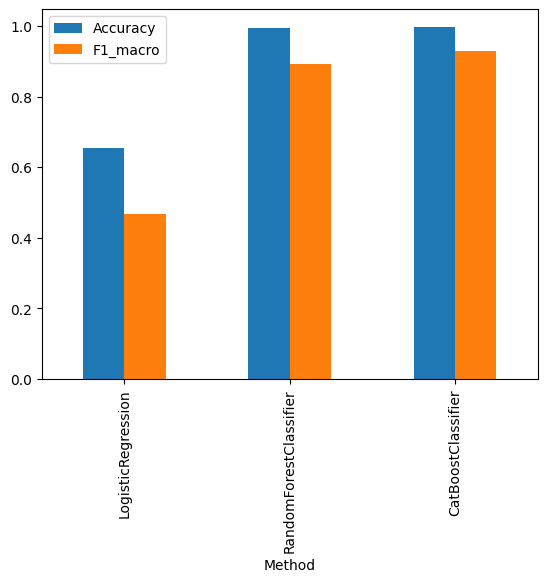

In [5]:
data_final[['Мethod', 'Accuracy', 'F1_macro']].plot(x='Мethod', kind='bar')

### Сохранение модели

In [ ]:
model_bas_cb.save_model('model.cbm', format="cbm")


### Читаем модель и тестируем на тестовых данных

In [ ]:
model = CatBoostClassifier()      # parameters not required.
model.load_model('model.cbm')


preds = model.predict(features_test)

print('Метрики тестовых данных:')
preds
print(' ')
print ("Accuracy:",accuracy_score(target_test, preds))
print ("F1_macro:", f1_score(target_test, preds, average='macro'))


F1 на тесте чуть хуже, но это нормально наверное.